In [74]:
import rebound
import numpy as np
import pandas as pd
import dask.dataframe as dd
from collections import OrderedDict
from celmech.poincare import Poincare, PoincareHamiltonian
from celmech import Andoyer, AndoyerHamiltonian
from celmech.resonances import resonant_period_ratios, resonance_intersections_list, resonance_pratio_span
from celmech.transformations import masses_to_jacobi
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Are initially closest Zcross planets always the ones that collide?


In [75]:
path = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/'
TTVpath = 'data/TTVsystems/KOI-0314/simulation_archives/runs/sa'
respath = 'data/resonant/simulation_archives/runs/sa'

sa = rebound.SimulationArchive(path+respath+'0000018.bin')
tmax = sa[1].t
sim = sa[0]

In [76]:
P12 = []
P23 = []
ts = []
print(sa[-1].t)
for sim in sa:
    ps = sim.particles
    P12.append(ps[2].P/ps[1].P)
    P23.append(ps[3].P/ps[2].P)
    ts.append(sim.t)

98716780.65077779


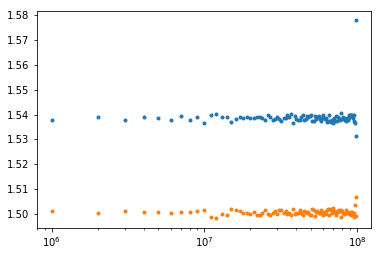

In [77]:
fig, ax = plt.subplots()
ax.plot(ts, P12, '.')
ax.plot(ts, P23, '.')
ax.set_xscale('log')

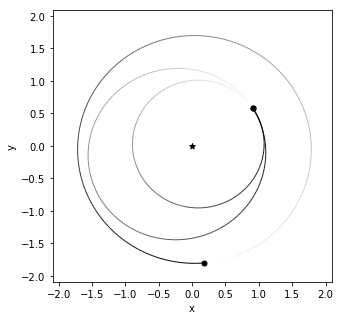

In [78]:
fig = rebound.OrbitPlot(sa[-1])

In [84]:
testwhichcollide(18)

18 [1, 2]
1 2 0.3324108582092001 0.23999702931898242 15.551156662867278 0.017792805819961604
1 3 0.7469540006319869 0.0736763738040673 20.91436021413173 -1
2 3 0.31112260896758615 0.20718678331496967 8.885856351449792 1.149064101582099
[2, 3] [1, 2] [2, 3]


(1, 0, 1, 0, 0)

In [79]:
def findres2(sim, i1, i2):
    delta = 0.03
    maxorder = 2
    ps = Poincare.from_Simulation(sim=sim).particles # get averaged mean motions
    n1 = ps[i1].n
    n2 = ps[i2].n

    m1 = ps[i1].m/ps[i1].M
    m2 = ps[i2].m/ps[i2].M

    Pratio = n2/n1
    if np.isnan(Pratio): # probably due to close encounter where averaging step doesn't converge 
        return np.nan, np.nan, np.nan

    res = resonant_period_ratios(Pratio-delta,Pratio+delta, order=maxorder)

    Z = np.sqrt((ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega))**2 + (ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega))**2)

    maxstrength = 0
    j, k, i1, i2, strength = -1, -1, -1, -1, -1
    for a, b in res:
        s = np.abs(np.sqrt(m1+m2)*Z**((b-a)/2.)/((b*n2 - a*n1)/n1))
        #print('{0}:{1}'.format(b, a), (b*n2 - a*n1), s)
        if s > maxstrength:
            j = b
            k = b-a
            
            strength=s
            maxstrength = s

    return j, k, strength



In [83]:
def testwhichcollide(ID, Nunstable=0, NZcross=0, NemZc=0, Nbeta=0, Nstrength=0):
    try:
        sa = rebound.SimulationArchive(path+respath+'{0:07d}.bin'.format(ID))
    except:
        return Nunstable, NZcross, NemZc, Nbeta, Nstrength

    simf = sa[-1]
    if simf.t > 9.98e8:
        return Nunstable, NZcross, NemZc, Nbeta, Nstrength
    else:
        Nunstable += 1
        
    N = simf.N
    ps = simf.particles
    mindRH = 100.
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1 = int(i1)
        i2 = int(i2)
        d = np.sqrt((ps[i1].x-ps[i2].x)**2 + (ps[i1].y-ps[i2].y)**2 + (ps[i1].z-ps[i2].z)**2)
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        if d/RH < mindRH:
            dRHi = [i1, i2]
            mindRH = d/RH
    print(ID, dRHi)
    
    sim = sa[0]
    Zcross, RH, beta, emZc = np.zeros(3), np.zeros(3), np.zeros(3), np.zeros(3)
    N = sim.N
    ps = sim.particles
    
    minZcross = 1.
    maxemZc = 0.
    minbeta = 20.
    maxstrength = 0.
    strengthi = [0,0]
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1 = int(i1)
        i2 = int(i2)
        j, k, strength = findres2(sim, i1, i2)
        Zcross = (ps[i2].a-ps[i1].a)/ps[i1].a
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        beta = (ps[i2].a-ps[i1].a)/RH
        emZc = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)/Zcross
        if Zcross < minZcross:
            Zcrossi = [i1, i2]
            minZcross = Zcross
        if emZc > maxemZc:
            emZci = [i1, i2]
            maxemZc = emZc
        if beta < minbeta:
            betai = [i1, i2]
            minbeta = beta
        if strength > maxstrength:
            strengthi = [i1, i2]
            maxstrength = strength
        print(i1, i2, Zcross, emZc, beta, strength)
    print(Zcrossi, emZci, betai)
    
    if Zcrossi == dRHi:
        NZcross += 1
    if emZci == dRHi:
        NemZc += 1
    if betai == dRHi:
        Nbeta += 1
    if strengthi == dRHi:
        Nstrength += 1
    return Nunstable, NZcross, NemZc, Nbeta, Nstrength

In [17]:
Nsystems = 9998
Nunstable = 0
NZcross = 0
NemZc = 0
Nbeta = 0
Nstrength = 0
for i in range(Nsystems):
    Nunstable, NZcross, NemZc, Nbeta, Nstrength = testwhichcollide(i, Nunstable, NZcross, NemZc, Nbeta, Nstrength)
print(NZcross/Nunstable)
print(NemZc/Nunstable)
print(Nbeta/Nunstable)
print(Nstrength/Nunstable)

0.7435793457691268
0.6734252500675858
0.6542308732089754
0.47661530143281966


In [90]:
simf = sa[-1]
Zcross = np.zeros(3)
N = simf.N
ps = simf.particles
for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
    i1 = int(i1)
    i2 = int(i2)
    d = np.sqrt((ps[i1].x-ps[i2].x)**2 + (ps[i1].y-ps[i2].y)**2 + (ps[i1].z-ps[i2].z)**2)
    RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
    print(i1, i2, d/RH)

1 2 125.763192437951
1 3 124.1841466861845
2 3 0.5337972549436412


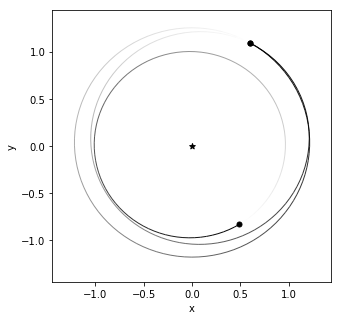

In [91]:
fig = rebound.OrbitPlot(simf)

In [ ]:
Norbits = 10000
Nout = 1000

###############################
sim.collision_resolve = collision
sim.ri_whfast.keep_unsynchronized = 1
sim.ri_whfast.safe_mode = 0
##############################

features = OrderedDict()
AMDcoeffs = AMD_stability_coefficients(sim)
features["C_AMD12"] = AMDcoeffs[0]
features["C_AMD23"] = AMDcoeffs[1]
features["C_AMD_max"] = np.max(AMDcoeffs)

ps = sim.particles
sim.init_megno()

N = sim.N - sim.N_var
a0 = [0] + [sim.particles[i].a for i in range(1, N)]
Npairs = int((N-1)*(N-2)/2)
js, ks, strengths = np.zeros(Npairs, dtype=np.int), np.zeros(Npairs, dtype=np.int), np.zeros(Npairs)
maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = -1, -1, -1, -1, -1, -1

Zcross = np.zeros(Npairs)
#print('pairindex, i1, i2, j, k, strength')
for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
    js[i], ks[i], strengths[i] = findres2(sim, i1, i2)
    Zcross[i] = (ps[int(i2)].a-ps[int(i1)].a)/ps[int(i1)].a
    #print(i, i1, i2, js[i], ks[i], strengths[i])
    if strengths[i] > maxstrength:
        maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = js[i], ks[i], i1, i2, i, strengths[i]

features['Zcross12'] = Zcross[0]
features['Zcross13'] = Zcross[1]
features['Zcross23'] = Zcross[2]
features['maxj'] = maxj
features['maxk'] = maxk
features['maxi1'] = maxi1
features['maxi2'] = maxi2
features['maxstrength'] = maxstrength

sortedstrengths = strengths.copy()
sortedstrengths.sort()
if sortedstrengths[-1] > 0 and sortedstrengths[-2] > 0:
    features['secondres'] = sortedstrengths[-2]/sortedstrengths[-1]
else:
    features['secondres'] = -1

#print('max', maxi1, maxi2, maxj, maxk, maxpairindex, maxstrength)
#print('df (j, k, pairindex):', features['j'], features['k'], features['pairindex'])
P0 = sim.particles[1].P
times = np.linspace(0, Norbits, Nout)

eminus = np.zeros((Npairs, Nout))
rebound_Z, rebound_phi = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
rebound_Zcom, rebound_phiZcom = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
rebound_Zstar, rebound_dKprime = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
celmech_Z, celmech_phi = np.zeros(Nout), np.zeros(Nout)
celmech_Zcom, celmech_phiZcom = np.zeros(Nout), np.zeros(Nout)
celmech_Zstar, celmech_dKprime = np.zeros(Nout), np.zeros(Nout)

    for i,t in enumerate(times):
    for j, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1, i2 = int(i1), int(i2)
        eminus[j, i] = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)
        if js[j] != -1:
            pvars = Poincare.from_Simulation(sim)
            avars = Andoyer.from_Poincare(pvars, j=js[j], k=ks[j], a10=a0[i1], i1=i1, i2=i2)
            rebound_Z[j, i] = avars.Z
            rebound_phi[j, i] = avars.phi
            rebound_Zcom[j, i] = avars.Zcom
            rebound_phiZcom[j, i] = avars.phiZcom
            rebound_Zstar[j, i] = avars.Zstar
            rebound_dKprime[j, i] = avars.dKprime
    try:
        sim.integrate(t*P0, exact_finish_time=0)
    except:
        break

mask = eminus[0] > 0 # where there are data points in case sim ends early
times = times[mask]
eminus = eminus[:, mask]
rebound_Z, rebound_phi = rebound_Z[:, mask], rebound_phi[:, mask]
rebound_Zcom, rebound_phiZcom =  rebound_Zcom[:, mask], rebound_phiZcom[:, mask]
rebound_Zstar, rebound_dKprime = rebound_Zstar[:, mask], rebound_dKprime[:, mask]
celmech_Z, celmech_phi, celmech_Zcom, celmech_phiZcom = celmech_Z[mask], celmech_phi[mask], celmech_Zcom[mask], celmech_phiZcom[mask]
celmech_Zstar, celmech_dKprime = celmech_Zstar[mask], celmech_dKprime[mask]
for i, s in zip([0,2], ['12', '23']): # take adjacent ones
    EM = eminus[i]
    Zc = Zcross[i]
    features['EMmed'+s] = np.median(EM)/Zc
    features['EMmax'+s] = EM.max()/Zc
    try:
        p = np.poly1d(np.polyfit(times, EM, 3))
        m = p(times)
        EMdrift = np.abs((m[-1]-m[0])/m[0])
        features['EMdrift'+s] = EMdrift
    except:
        features['EMdrift'+s] = np.nan
    maxindex = (m == m.max()).nonzero()[0][0] # index where cubic polynomial fit to EM reaches max to track long wavelength variations (secular?)
    if EMdrift > 0.1 and (maxindex < 0.01*Nout or maxindex > 0.99*Nout): # don't flag as not capturing secular if Z isn't varying significantly in first place
        features['capseculartscale'+s] = 0
    else:
        features['capseculartscale'+s] = 1
    features['EMdetrendedstd'+s] = pd.Series(EM-m).std()/EM[0]
    rollstd = pd.Series(EM).rolling(window=100).std()
    features['EMrollingstd'+s] = rollstd[100:].median()/EM[0]
    var = [EM[:j].var() for j in range(len(EM))]
    try:
        p = np.poly1d(np.polyfit(times[len(var)//2:], var[len(var)//2:], 1)) # fit only second half to get rid of transient
        features['DiffcoeffEM'+s] = p[1]/Zc**2
    except:
        features['DiffcoeffEM'+s] = np.nan
    features['medvarEM'+s] = np.median(var[len(var)//2:])/Zc**2
    if strengths[i] != -1:
        Z = rebound_Z[i]
        features['Zmed'+s] = np.median(Z)/Zc
        features['Zmax'+s] = rebound_Z[i].max()/Zc
        try:
            p = np.poly1d(np.polyfit(times, Z, 3))
            m = p(times)
            features['Zdetrendedstd'+s] = pd.Series(Z-m).std()/Z[0]
        except:
            features['Zdetrendedstd'+s] = np.nan
        rollstd = pd.Series(Z).rolling(window=100).std()
        features['Zrollingstd'+s] = rollstd[100:].median()/Z[0]
        var = [Z[:j].var() for j in range(len(Z))]
        try:
            p = np.poly1d(np.polyfit(times[len(var)//2:], var[len(var)//2:], 1)) # fit only second half to get rid of transient
            features['DiffcoeffZ'+s] = p[1]/Zc**2
        except:
            features['DiffcoeffZ'+s] = np.nan
        features['medvarZ'+s] = np.median(var[len(var)//2:])/Zc**2
        features['Zcomdrift'+s] = np.max(np.abs(rebound_Zcom[i]-rebound_Zcom[i, 0])/rebound_Zcom[i, 0])
        rollstd = pd.Series(rebound_Zcom[i]).rolling(window=100).std()
        features['Zcomrollingstd'+s] = rollstd[100:].median()/rebound_Zcom[i,0]
        features['phiZcomdrift'+s] = np.max(np.abs(rebound_phiZcom[i]-rebound_phiZcom[i, 0]))
        rollstd = pd.Series(rebound_phiZcom[i]).rolling(window=100).std()
        features['phiZcomrollingstd'+s] = rollstd[100:].median()
        features['Zstardrift'+s] = np.max(np.abs(rebound_Zstar[i]-rebound_Zstar[i, 0])/rebound_Zstar[i, 0])
        rollstd = pd.Series(rebound_Zstar[i]).rolling(window=100).std()
        features['Zstarrollingstd'+s] = rollstd[100:].median()/rebound_Zstar[i,0]
        Zcosphi = Z*np.cos(rebound_phi[i])
        features['Zcosphistd'+s] = Zcosphi.std()/Zc
        features['medZcosphi'+s] = np.median(Zcosphi)/Zc
    else:
        features['Zmed'+s] = -1
        features['Zmax'+s] = -1
        features['Zdetrendedstd'+s] = -1
        features['Zrollingstd'+s] = -1
        features['DiffcoeffZ'+s] = -1
        features['medvarZ'+s] = -1
        features['Zcomdrift'+s] = -1
        features['Zcomrollingstd'+s] = -1
        features['phiZcomdrift'+s] = -1
        features['phiZcomrollingstd'+s] = -1
        features['Zstardrift'+s] = -1
        features['Zstarrollingstd'+s] = -1
        features['Zcosphistd'+s] = -1
        features['medZcosphi'+s] = -1

tlyap = 1./np.abs(sim.calculate_lyapunov())/P0
if tlyap > Norbits:
    tlyap = Norbits
features['tlyap'] = tlyap
features['megno'] = sim.calculate_megno()
return pd.Series(features, index=list(features.keys()))